In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data 

In [2]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

data_path = "../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)


# Model 

In [19]:
keras.backend.clear_session()

dim_triu = dim * (dim + 1) // 2
activation = "elu"
learning_rate = 1e-5
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

model = keras.Sequential()

# input layer
model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

# hidden
#for i in range(3):

model.add(keras.layers.Dense(
    dim_triu+150, 
    activation=activation, 
    kernel_initializer=intializer, 
    #bias_initializer='zeros',
    #kernel_regularizer=keras.regularizers.l2(1e-8)
))

model.add(keras.layers.Dense(
        dim_triu + 50, 
        activation=activation, 
        kernel_initializer=intializer, 
        #bias_initializer='zeros',
        #kernel_regularizer=keras.regularizers.l2(1e-8)
))


#output
model.add(keras.layers.Dense(dim_triu))

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])

# Training


In [20]:
mse = []
mse_val = []
learning_rate = []

In [21]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-5, 
    patience=100, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=20, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-4, 
    cooldown=50, 
    min_lr=1e-10
)

class LoggLearningRate(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        learning_rate.append(keras.backend.eval(self.model.optimizer.lr))
        
logg_lr = LoggLearningRate()

In [22]:
epochs = 10000
n_resets = 5

for i in range(n_resets):
    keras.backend.set_value(model.optimizer.lr, 1e-4)

    history = model.fit(
        x = s_train,
        y = p_train,
        epochs=epochs,
        shuffle=True,
        validation_data=(s_test, p_test), 
        verbose=1, 
        callbacks=[
            early_stopping, 
            reduce_lr,
            logg_lr
        ]
    )
    
    mse += history.history["loss"]
    mse_val += history.history["val_loss"]
    
    print("\n\n\n\n\nNext rouuund!!\n\n")

Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 1s 860us/step - loss: 0.0966 - mean_absolute_error: 0.1452 - mean_squared_error: 0.0966 - val_loss: 0.0848 - val_mean_absolute_error: 0.1359 - val_mean_squared_error: 0.0848
Epoch 2/10000
800/800 [==============================] - 0s 462us/step - loss: 0.0518 - mean_absolute_error: 0.1131 - mean_squared_error: 0.0518 - val_loss: 0.0168 - val_mean_absolute_error: 0.0811 - val_mean_squared_error: 0.0168
Epoch 3/10000
800/800 [==============================] - 0s 515us/step - loss: 0.0096 - mean_absolute_error: 0.0619 - mean_squared_error: 0.0096 - val_loss: 0.0067 - val_mean_absolute_error: 0.0514 - val_mean_squared_error: 0.0067
Epoch 4/10000
800/800 [==============================] - 0s 487us/step - loss: 0.0060 - mean_absolute_error: 0.0485 - mean_squared_error: 0.0060 - val_loss: 0.0057 - val_mean_absolute_error: 0.0467 - val_mean_squared_error: 0.0057
Epoch 5/10000
800/800 [=======

800/800 [==============================] - 0s 474us/step - loss: 0.0012 - mean_absolute_error: 0.0233 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_absolute_error: 0.0241 - val_mean_squared_error: 0.0013
Epoch 37/10000
800/800 [==============================] - 0s 422us/step - loss: 0.0012 - mean_absolute_error: 0.0229 - mean_squared_error: 0.0012 - val_loss: 0.0013 - val_mean_absolute_error: 0.0238 - val_mean_squared_error: 0.0013
Epoch 38/10000
800/800 [==============================] - 0s 436us/step - loss: 0.0011 - mean_absolute_error: 0.0227 - mean_squared_error: 0.0011 - val_loss: 0.0013 - val_mean_absolute_error: 0.0236 - val_mean_squared_error: 0.0013
Epoch 39/10000
800/800 [==============================] - 0s 449us/step - loss: 0.0011 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0011 - val_loss: 0.0012 - val_mean_absolute_error: 0.0233 - val_mean_squared_error: 0.0012
Epoch 40/10000
800/800 [==============================] - 0s 446us/step - loss: 0.0011 

Epoch 70/10000
800/800 [==============================] - 0s 480us/step - loss: 5.1714e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 5.1714e-04 - val_loss: 6.0296e-04 - val_mean_absolute_error: 0.0168 - val_mean_squared_error: 6.0296e-04
Epoch 71/10000
800/800 [==============================] - 0s 435us/step - loss: 5.0585e-04 - mean_absolute_error: 0.0154 - mean_squared_error: 5.0585e-04 - val_loss: 5.8499e-04 - val_mean_absolute_error: 0.0165 - val_mean_squared_error: 5.8499e-04
Epoch 72/10000
800/800 [==============================] - 0s 441us/step - loss: 4.9896e-04 - mean_absolute_error: 0.0153 - mean_squared_error: 4.9896e-04 - val_loss: 6.1751e-04 - val_mean_absolute_error: 0.0169 - val_mean_squared_error: 6.1751e-04
Epoch 73/10000
800/800 [==============================] - 0s 468us/step - loss: 5.1562e-04 - mean_absolute_error: 0.0155 - mean_squared_error: 5.1562e-04 - val_loss: 5.9572e-04 - val_mean_absolute_error: 0.0166 - val_mean_squared_error: 5.9572e-04
Epoch 74

800/800 [==============================] - 0s 461us/step - loss: 2.9108e-04 - mean_absolute_error: 0.0118 - mean_squared_error: 2.9108e-04 - val_loss: 3.5205e-04 - val_mean_absolute_error: 0.0129 - val_mean_squared_error: 3.5205e-04
Epoch 104/10000
800/800 [==============================] - 0s 436us/step - loss: 2.8613e-04 - mean_absolute_error: 0.0117 - mean_squared_error: 2.8613e-04 - val_loss: 3.4915e-04 - val_mean_absolute_error: 0.0128 - val_mean_squared_error: 3.4915e-04
Epoch 105/10000
800/800 [==============================] - 0s 443us/step - loss: 2.8398e-04 - mean_absolute_error: 0.0117 - mean_squared_error: 2.8398e-04 - val_loss: 3.4736e-04 - val_mean_absolute_error: 0.0128 - val_mean_squared_error: 3.4736e-04
Epoch 106/10000
800/800 [==============================] - 0s 435us/step - loss: 2.8303e-04 - mean_absolute_error: 0.0117 - mean_squared_error: 2.8303e-04 - val_loss: 3.4678e-04 - val_mean_absolute_error: 0.0128 - val_mean_squared_error: 3.4678e-04
Epoch 107/10000
800/

Epoch 136/10000
800/800 [==============================] - 0s 435us/step - loss: 1.8471e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.8471e-04 - val_loss: 2.3597e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 2.3597e-04
Epoch 137/10000
800/800 [==============================] - 0s 453us/step - loss: 1.8436e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.8436e-04 - val_loss: 2.3558e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 2.3558e-04
Epoch 138/10000
800/800 [==============================] - 0s 440us/step - loss: 1.8419e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.8419e-04 - val_loss: 2.3550e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 2.3550e-04
Epoch 139/10000
800/800 [==============================] - 0s 446us/step - loss: 1.8375e-04 - mean_absolute_error: 0.0094 - mean_squared_error: 1.8375e-04 - val_loss: 2.3500e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 2.3500e-04
Epoc

Epoch 169/10000
800/800 [==============================] - 0s 432us/step - loss: 1.7557e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.7557e-04 - val_loss: 2.2494e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 2.2494e-04
Epoch 170/10000
800/800 [==============================] - 0s 434us/step - loss: 1.7534e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.7534e-04 - val_loss: 2.2430e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 2.2430e-04
Epoch 171/10000
800/800 [==============================] - 0s 454us/step - loss: 1.7513e-04 - mean_absolute_error: 0.0092 - mean_squared_error: 1.7513e-04 - val_loss: 2.2456e-04 - val_mean_absolute_error: 0.0103 - val_mean_squared_error: 2.2456e-04
Epoch 172/10000
800/800 [==============================] - 0s 454us/step - loss: 1.7495e-04 - mean_absolute_error: 0.0091 - mean_squared_error: 1.7495e-04 - val_loss: 2.2318e-04 - val_mean_absolute_error: 0.0102 - val_mean_squared_error: 2.2318e-04
Epoc

800/800 [==============================] - 0s 450us/step - loss: 1.6462e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.6462e-04 - val_loss: 2.1232e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 2.1232e-04
Epoch 202/10000
800/800 [==============================] - 0s 452us/step - loss: 1.6430e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.6430e-04 - val_loss: 2.1218e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 2.1218e-04
Epoch 203/10000
800/800 [==============================] - 0s 443us/step - loss: 1.6420e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.6420e-04 - val_loss: 2.1211e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 2.1211e-04
Epoch 204/10000
800/800 [==============================] - 0s 451us/step - loss: 1.6415e-04 - mean_absolute_error: 0.0089 - mean_squared_error: 1.6415e-04 - val_loss: 2.1203e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 2.1203e-04
Epoch 205/10000
800/

Epoch 234/10000
800/800 [==============================] - 0s 428us/step - loss: 1.6303e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6303e-04 - val_loss: 2.1071e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 2.1071e-04
Epoch 235/10000
800/800 [==============================] - 0s 445us/step - loss: 1.6301e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6301e-04 - val_loss: 2.1063e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.1063e-04
Epoch 236/10000
800/800 [==============================] - 0s 429us/step - loss: 1.6297e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6297e-04 - val_loss: 2.1048e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.1048e-04
Epoch 237/10000
800/800 [==============================] - 0s 441us/step - loss: 1.6296e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6296e-04 - val_loss: 2.1062e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.1062e-04
Epoc

Epoch 267/10000
800/800 [==============================] - 0s 437us/step - loss: 1.6162e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6162e-04 - val_loss: 2.0895e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0895e-04
Epoch 268/10000
800/800 [==============================] - 0s 458us/step - loss: 1.6161e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6161e-04 - val_loss: 2.0887e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0887e-04
Epoch 269/10000
800/800 [==============================] - 0s 456us/step - loss: 1.6157e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6157e-04 - val_loss: 2.0888e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0888e-04

Epoch 00269: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 270/10000
800/800 [==============================] - 0s 444us/step - loss: 1.6133e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6133e-04 - val_loss: 2.088

800/800 [==============================] - 0s 444us/step - loss: 1.6118e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6118e-04 - val_loss: 2.0864e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0864e-04
Epoch 300/10000
800/800 [==============================] - 0s 448us/step - loss: 1.6118e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6118e-04 - val_loss: 2.0865e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0865e-04
Epoch 301/10000
800/800 [==============================] - 0s 423us/step - loss: 1.6117e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6117e-04 - val_loss: 2.0862e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0862e-04
Epoch 302/10000
800/800 [==============================] - 0s 466us/step - loss: 1.6116e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6116e-04 - val_loss: 2.0861e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0861e-04
Epoch 303/10000
800/

Epoch 332/10000
800/800 [==============================] - 0s 423us/step - loss: 1.6101e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6101e-04 - val_loss: 2.0842e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0842e-04
Epoch 333/10000
800/800 [==============================] - 0s 454us/step - loss: 1.6100e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6100e-04 - val_loss: 2.0841e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0841e-04
Epoch 334/10000
800/800 [==============================] - 0s 431us/step - loss: 1.6100e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6100e-04 - val_loss: 2.0841e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0841e-04
Epoch 335/10000
800/800 [==============================] - 0s 414us/step - loss: 1.6100e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.6100e-04 - val_loss: 2.0839e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 2.0839e-04
Epoc

800/800 [==============================] - 0s 444us/step - loss: 1.2229e-04 - mean_absolute_error: 0.0077 - mean_squared_error: 1.2229e-04 - val_loss: 1.5837e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.5837e-04
Epoch 26/10000
800/800 [==============================] - 0s 443us/step - loss: 1.2180e-04 - mean_absolute_error: 0.0077 - mean_squared_error: 1.2180e-04 - val_loss: 1.5814e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.5814e-04
Epoch 27/10000
800/800 [==============================] - 0s 462us/step - loss: 1.2161e-04 - mean_absolute_error: 0.0077 - mean_squared_error: 1.2161e-04 - val_loss: 1.5769e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.5769e-04
Epoch 28/10000
800/800 [==============================] - 0s 456us/step - loss: 1.2145e-04 - mean_absolute_error: 0.0077 - mean_squared_error: 1.2145e-04 - val_loss: 1.5813e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.5813e-04
Epoch 29/10000
800/800 

800/800 [==============================] - 0s 424us/step - loss: 1.1669e-04 - mean_absolute_error: 0.0075 - mean_squared_error: 1.1669e-04 - val_loss: 1.5150e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.5150e-04
Epoch 59/10000
800/800 [==============================] - 0s 434us/step - loss: 1.1641e-04 - mean_absolute_error: 0.0075 - mean_squared_error: 1.1641e-04 - val_loss: 1.5100e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.5100e-04
Epoch 60/10000
800/800 [==============================] - 0s 442us/step - loss: 1.1620e-04 - mean_absolute_error: 0.0075 - mean_squared_error: 1.1620e-04 - val_loss: 1.5128e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.5128e-04
Epoch 61/10000
800/800 [==============================] - 0s 426us/step - loss: 1.1603e-04 - mean_absolute_error: 0.0075 - mean_squared_error: 1.1603e-04 - val_loss: 1.5081e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.5081e-04
Epoch 62/10000
800/800 

800/800 [==============================] - 0s 442us/step - loss: 1.1079e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.1079e-04 - val_loss: 1.4398e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.4398e-04
Epoch 92/10000
800/800 [==============================] - 0s 453us/step - loss: 1.1057e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.1057e-04 - val_loss: 1.4346e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.4346e-04

Epoch 00092: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 93/10000
800/800 [==============================] - 0s 437us/step - loss: 1.0926e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.0926e-04 - val_loss: 1.4289e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 1.4289e-04
Epoch 94/10000
800/800 [==============================] - 0s 434us/step - loss: 1.0882e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.0882e-04 - val_loss: 1.4275e-04 - val_mean_ab

Epoch 124/10000
800/800 [==============================] - 0s 441us/step - loss: 1.0813e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.0813e-04 - val_loss: 1.4194e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4194e-04
Epoch 125/10000
800/800 [==============================] - 0s 447us/step - loss: 1.0813e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.0813e-04 - val_loss: 1.4186e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4186e-04
Epoch 126/10000
800/800 [==============================] - 0s 443us/step - loss: 1.0810e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.0810e-04 - val_loss: 1.4191e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4191e-04
Epoch 127/10000
800/800 [==============================] - 0s 441us/step - loss: 1.0805e-04 - mean_absolute_error: 0.0073 - mean_squared_error: 1.0805e-04 - val_loss: 1.4183e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4183e-04
Epoc

Epoch 157/10000
800/800 [==============================] - 0s 430us/step - loss: 1.0735e-04 - mean_absolute_error: 0.0072 - mean_squared_error: 1.0735e-04 - val_loss: 1.4091e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4091e-04
Epoch 158/10000
800/800 [==============================] - 0s 460us/step - loss: 1.0732e-04 - mean_absolute_error: 0.0072 - mean_squared_error: 1.0732e-04 - val_loss: 1.4093e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4093e-04
Epoch 159/10000
800/800 [==============================] - 0s 424us/step - loss: 1.0729e-04 - mean_absolute_error: 0.0072 - mean_squared_error: 1.0729e-04 - val_loss: 1.4085e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4085e-04
Epoch 160/10000
800/800 [==============================] - 0s 442us/step - loss: 1.0727e-04 - mean_absolute_error: 0.0072 - mean_squared_error: 1.0727e-04 - val_loss: 1.4079e-04 - val_mean_absolute_error: 0.0082 - val_mean_squared_error: 1.4079e-04
Epoc

Epoch 23/10000
800/800 [==============================] - 0s 441us/step - loss: 8.2479e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 8.2479e-05 - val_loss: 1.0794e-04 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 1.0794e-04
Epoch 24/10000
800/800 [==============================] - 0s 435us/step - loss: 8.1858e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 8.1858e-05 - val_loss: 1.0813e-04 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 1.0813e-04
Epoch 25/10000
800/800 [==============================] - 0s 446us/step - loss: 8.1636e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 8.1636e-05 - val_loss: 1.0741e-04 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 1.0741e-04
Epoch 26/10000
800/800 [==============================] - 0s 449us/step - loss: 8.1503e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 8.1503e-05 - val_loss: 1.0716e-04 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 1.0716e-04
Epoch 27

800/800 [==============================] - 0s 428us/step - loss: 7.8366e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 7.8366e-05 - val_loss: 1.0352e-04 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 1.0352e-04
Epoch 57/10000
800/800 [==============================] - 0s 425us/step - loss: 7.8334e-05 - mean_absolute_error: 0.0063 - mean_squared_error: 7.8334e-05 - val_loss: 1.0265e-04 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 1.0265e-04
Epoch 58/10000
800/800 [==============================] - 0s 454us/step - loss: 7.8155e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 7.8155e-05 - val_loss: 1.0304e-04 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 1.0304e-04
Epoch 59/10000
800/800 [==============================] - 0s 432us/step - loss: 7.8057e-05 - mean_absolute_error: 0.0062 - mean_squared_error: 7.8057e-05 - val_loss: 1.0289e-04 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 1.0289e-04
Epoch 60/10000
800/800 

800/800 [==============================] - 0s 429us/step - loss: 7.4438e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 7.4438e-05 - val_loss: 9.8214e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.8214e-05
Epoch 90/10000
800/800 [==============================] - 0s 433us/step - loss: 7.4460e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 7.4460e-05 - val_loss: 9.7826e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.7826e-05

Epoch 00090: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 91/10000
800/800 [==============================] - 0s 446us/step - loss: 7.3334e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 7.3334e-05 - val_loss: 9.7195e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.7195e-05
Epoch 92/10000
800/800 [==============================] - 0s 449us/step - loss: 7.2868e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.2868e-05 - val_loss: 9.7113e-05 - val_mean_ab

Epoch 122/10000
800/800 [==============================] - 0s 418us/step - loss: 7.2382e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.2382e-05 - val_loss: 9.6631e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.6631e-05
Epoch 123/10000
800/800 [==============================] - 0s 441us/step - loss: 7.2378e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.2378e-05 - val_loss: 9.6583e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.6583e-05
Epoch 124/10000
800/800 [==============================] - 0s 449us/step - loss: 7.2364e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.2364e-05 - val_loss: 9.6500e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.6500e-05
Epoch 125/10000
800/800 [==============================] - 0s 446us/step - loss: 7.2345e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.2345e-05 - val_loss: 9.6569e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.6569e-05
Epoc

Epoch 155/10000
800/800 [==============================] - 0s 456us/step - loss: 7.1892e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.1892e-05 - val_loss: 9.5918e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.5918e-05
Epoch 156/10000
800/800 [==============================] - 0s 442us/step - loss: 7.1896e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.1896e-05 - val_loss: 9.5989e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.5989e-05
Epoch 157/10000
800/800 [==============================] - 0s 439us/step - loss: 7.1870e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.1870e-05 - val_loss: 9.5838e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.5838e-05
Epoch 158/10000
800/800 [==============================] - 0s 432us/step - loss: 7.1838e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.1838e-05 - val_loss: 9.5895e-05 - val_mean_absolute_error: 0.0069 - val_mean_squared_error: 9.5895e-05
Epoc

800/800 [==============================] - 0s 424us/step - loss: 1.1210e-04 - mean_absolute_error: 0.0076 - mean_squared_error: 1.1210e-04 - val_loss: 1.1886e-04 - val_mean_absolute_error: 0.0078 - val_mean_squared_error: 1.1886e-04
Epoch 6/10000
800/800 [==============================] - 0s 444us/step - loss: 9.1332e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 9.1332e-05 - val_loss: 1.0690e-04 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 1.0690e-04
Epoch 7/10000
800/800 [==============================] - 0s 438us/step - loss: 8.4789e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 8.4789e-05 - val_loss: 1.0608e-04 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 1.0608e-04
Epoch 8/10000
800/800 [==============================] - 0s 441us/step - loss: 8.2928e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 8.2928e-05 - val_loss: 1.0184e-04 - val_mean_absolute_error: 0.0073 - val_mean_squared_error: 1.0184e-04
Epoch 9/10000
800/800 [===

Epoch 38/10000
800/800 [==============================] - 0s 435us/step - loss: 5.4854e-05 - mean_absolute_error: 0.0053 - mean_squared_error: 5.4854e-05 - val_loss: 7.3999e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 7.3999e-05
Epoch 39/10000
800/800 [==============================] - 0s 439us/step - loss: 5.4790e-05 - mean_absolute_error: 0.0053 - mean_squared_error: 5.4790e-05 - val_loss: 7.3810e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 7.3810e-05
Epoch 40/10000
800/800 [==============================] - 0s 420us/step - loss: 5.4701e-05 - mean_absolute_error: 0.0053 - mean_squared_error: 5.4701e-05 - val_loss: 7.3901e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 7.3901e-05
Epoch 41/10000
800/800 [==============================] - 0s 446us/step - loss: 5.4625e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 5.4625e-05 - val_loss: 7.3684e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 7.3684e-05
Epoch 42

800/800 [==============================] - 0s 418us/step - loss: 5.2864e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 5.2864e-05 - val_loss: 7.1319e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 7.1319e-05
Epoch 72/10000
800/800 [==============================] - 0s 448us/step - loss: 5.2675e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 5.2675e-05 - val_loss: 7.1486e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 7.1486e-05
Epoch 73/10000
800/800 [==============================] - 0s 438us/step - loss: 5.2708e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 5.2708e-05 - val_loss: 7.1304e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 7.1304e-05
Epoch 74/10000
800/800 [==============================] - 0s 445us/step - loss: 5.2747e-05 - mean_absolute_error: 0.0052 - mean_squared_error: 5.2747e-05 - val_loss: 7.1096e-05 - val_mean_absolute_error: 0.0059 - val_mean_squared_error: 7.1096e-05
Epoch 75/10000
800/800 

Epoch 104/10000
800/800 [==============================] - 0s 465us/step - loss: 4.9997e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.9997e-05 - val_loss: 6.8425e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.8425e-05
Epoch 105/10000
800/800 [==============================] - 0s 432us/step - loss: 4.9992e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.9992e-05 - val_loss: 6.8430e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.8430e-05
Epoch 106/10000
800/800 [==============================] - 0s 439us/step - loss: 4.9970e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.9970e-05 - val_loss: 6.8404e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.8404e-05
Epoch 107/10000
800/800 [==============================] - 0s 435us/step - loss: 4.9983e-05 - mean_absolute_error: 0.0050 - mean_squared_error: 4.9983e-05 - val_loss: 6.8433e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.8433e-05
Epoc

800/800 [==============================] - 0s 416us/step - loss: 6.1356e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 6.1356e-05 - val_loss: 7.6447e-05 - val_mean_absolute_error: 0.0063 - val_mean_squared_error: 7.6447e-05
Epoch 10/10000
800/800 [==============================] - 0s 441us/step - loss: 5.8570e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.8570e-05 - val_loss: 7.5562e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.5562e-05
Epoch 11/10000
800/800 [==============================] - 0s 429us/step - loss: 5.8890e-05 - mean_absolute_error: 0.0056 - mean_squared_error: 5.8890e-05 - val_loss: 7.2868e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 7.2868e-05
Epoch 12/10000
800/800 [==============================] - 0s 436us/step - loss: 5.6389e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.6389e-05 - val_loss: 7.0267e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 7.0267e-05
Epoch 13/10000
800/800 

Epoch 42/10000
800/800 [==============================] - 0s 465us/step - loss: 3.9869e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.9869e-05 - val_loss: 5.5108e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.5108e-05
Epoch 43/10000
800/800 [==============================] - 0s 436us/step - loss: 3.9862e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.9862e-05 - val_loss: 5.5050e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.5050e-05
Epoch 44/10000
800/800 [==============================] - 0s 443us/step - loss: 3.9792e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.9792e-05 - val_loss: 5.5096e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.5096e-05
Epoch 45/10000
800/800 [==============================] - 0s 457us/step - loss: 3.9733e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.9733e-05 - val_loss: 5.5002e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.5002e-05
Epoch 46

800/800 [==============================] - 0s 454us/step - loss: 3.8527e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.8527e-05 - val_loss: 5.3415e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.3415e-05
Epoch 76/10000
800/800 [==============================] - 0s 419us/step - loss: 3.8507e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.8507e-05 - val_loss: 5.3316e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.3316e-05
Epoch 77/10000
800/800 [==============================] - 0s 439us/step - loss: 3.8444e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.8444e-05 - val_loss: 5.3099e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.3099e-05
Epoch 78/10000
800/800 [==============================] - 0s 439us/step - loss: 3.8382e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.8382e-05 - val_loss: 5.3127e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.3127e-05
Epoch 79/10000
800/800 

Epoch 108/10000
800/800 [==============================] - 0s 436us/step - loss: 3.6741e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.6741e-05 - val_loss: 5.1643e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.1643e-05
Epoch 109/10000
800/800 [==============================] - 0s 470us/step - loss: 3.6723e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.6723e-05 - val_loss: 5.1674e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.1674e-05
Epoch 110/10000
800/800 [==============================] - 0s 421us/step - loss: 3.6721e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.6721e-05 - val_loss: 5.1659e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.1659e-05
Epoch 111/10000
800/800 [==============================] - 0s 448us/step - loss: 3.6722e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.6722e-05 - val_loss: 5.1684e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.1684e-05
Epoc

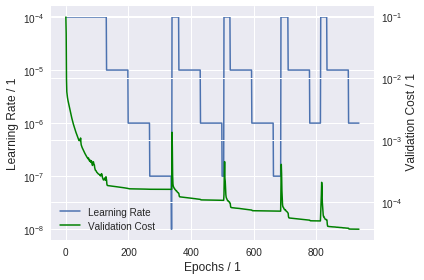

In [52]:
fig, ax1 = plt.subplots()

#ax1.semilogy(mse, label="Training")



ax1.semilogy(learning_rate, label="Learning Rate")
ax1.set_ylabel('Learning Rate / 1')
ax1.set_xlabel("Epochs / 1")

ax2 = ax1.twinx()
ax2.semilogy(mse, "g", label="Validation Cost")

ax2.set_ylabel(" Validation Cost / 1")


ax1.legend(bbox_to_anchor=(0, 0.06), loc=3)
ax2.legend(bbox_to_anchor=(0, 0), loc=3)

plt.tight_layout()

plt.savefig("/home/jcartus/Repos/MastersThesis/SMatrixDescriptor/figures/ExampleTrainingCost.pdf")

plt.show()


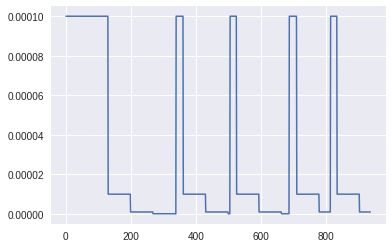